In [1]:
from collections import defaultdict
from pathlib import Path

import gurobipy as gp
import polars as pl
import pandas as pd
import numpy as np
from pandas.plotting import parallel_coordinates
from gurobipy import GRB

import os
import contextlib
import matplotlib.pyplot as plt


In [2]:
def get_data(data_dir: str, discount_factor: int = 5):
    df = pl.read_csv(
        Path(f"{data_dir}/alternatives.csv"), schema_overrides={"unit": pl.Int64}, infer_schema_length=1000
    )
    df = df.select(
        [
            "unit",
            "schedule",
            f"npv_{discount_factor}_percent",
            "stock_0",
            "stock_5",
            "stock_25",
            "harvest_value_5",
            "harvest_value_25",
            "stock_1_0",
            "stock_1_5",
            "stock_1_25",
            "stock_2_0",
            "stock_2_5",
            "stock_2_25",
            "stock_30_0",
            "stock_30_5",
            "stock_30_25",
        ]
    )
    df_keys = pl.read_csv(
        Path(f"{data_dir}/alternatives_key.csv"), schema_overrides={"unit": pl.Int64}, infer_schema_length=1000
    )
    df_keys = df_keys.drop("holding")
    # Split the treatments into multiple columns, to make them easier to read or whatever
    df_keys = df_keys.with_columns(
        [
            pl.when(pl.col("treatment").str.contains("_5"))
            .then(pl.col("treatment").str.extract(r"(\w+)_5", 1))
            .otherwise(pl.lit("donothing"))
            .alias("treatment_5"),
            pl.when(pl.col("treatment").str.contains("_25"))
            .then(pl.col("treatment").str.extract(r"(\w+)_25", 1))
            .otherwise(pl.lit("donothing"))
            .alias("treatment_25"),
        ]
    )

    df = df_keys.join(df, on=["unit", "schedule"], how="inner")
    return df


def get_scenario_data(data_dir: str):
    return pl.read_csv(Path(f"{data_dir}/scenario.csv"), schema_overrides={"unit": pl.Int64}, infer_schema_length=1000)

In [3]:
def tsrmop_asf(reference: dict, outputflag: int = 0):
    """This is the robust two stage model."""
    model = gp.Model()
    model.setParam("OutputFlag", outputflag)
    model.setParam("MIPGap", 1e-5)

    discount_factor = 5
    data_dirs = [
        "C:/MyTemp/data/two_stage_data/l1l23",
        "C:/MyTemp/data/two_stage_data/h1h23",
        "C:/MyTemp/data/two_stage_data/l1h23",
        "C:/MyTemp/data/two_stage_data/h1l23",
    ]
    n_scenarios = len(data_dirs)

    ideals = {
            "harvest5": 83939.39118553553,
            "harvest25": 425351.15530470666,
            "stock": 5985.184367164438,
            "npv": 310523.6483315748,
        }
    nadirs = {"harvest5": 0, "harvest25": 0, "stock": 260.7007001702532, "npv": 52844.33156539744}

    rho = 1e-6
    alpha = model.addVar(lb=-float("inf"))
    alphacons = [[],[],[],[]]
    normalsum = 0
    hsum5 = []
    hsum25 = []
    npvsum = []
    stocksum = []
    mvars = []
    unitsums = []
    harvest5 = []
    harvest25 = []
    stock = []
    npv = []
    x0_vars = {}
    x0_unit_sum = defaultdict(float)

    for i in range(n_scenarios):
        hsum5.append(0)
        hsum25.append(0)
        npvsum.append(0)
        stocksum.append(0)
        mvars.append({})
        unitsums.append(defaultdict(float))

        # df = get_data(data_dirs[i], discount_factor=discount_factor)
        df = get_scenario_data(data_dirs[i])

        for row in df.iter_rows(named=True):
            if (row["unit"], row["treatment_5"]) not in x0_vars:
                x0_vars[(row["unit"], row["treatment_5"])] = model.addVar(vtype=GRB.BINARY)
                x0_unit_sum[row["unit"]] += x0_vars[(row["unit"], row["treatment_5"])]
            new_var = model.addVar(vtype=GRB.BINARY)
            mvars[i][(row["unit"], row["treatment_5"], row["treatment_25"])] = new_var
            hsum5[i] += new_var * row["harvest_value_5"]
            hsum25[i] += new_var * row["harvest_value_25"]
            npvsum[i] += new_var * row[f"npv_{discount_factor}_percent"]
            stocksum[i] += new_var * row["stock_25"]
            unitsums[i][(row["unit"], row["treatment_5"])] += new_var

        for key in unitsums[i]:
            model.addConstr(unitsums[i][key] == x0_vars[key])

        harvest5.append(model.addVar())
        model.addConstr(harvest5[i] == hsum5[i])
        harvest25.append(model.addVar())
        model.addConstr(harvest25[i] == hsum25[i])
        stock.append(model.addVar())
        model.addConstr(stock[i] == stocksum[i])
        npv.append(model.addVar())
        model.addConstr(npv[i] == npvsum[i])

        objectives = {"harvest5": harvest5[i], "harvest25": harvest25[i], "stock": stock[i], "npv": npv[i]}

        normalsum = 0
        for obj in objectives:  # noqa: PLC0206
            normalsum += (objectives[obj] - reference[obj]) / (nadirs[obj] - ideals[obj])

        for obj in objectives:  # noqa: PLC0206
            alphacons[i].append(
                model.addConstr(
                    alpha >= (objectives[obj] - reference[obj]) / (nadirs[obj] - ideals[obj]) + rho * normalsum
                )
            )
            ##normalsum += objectives[obj] / (nadirs[obj] - ideals[obj])
        # model.addConstr(alpha >= -npv[i] + rho*normalsum)

    for unitsum in x0_unit_sum.values():
        model.addConstr(unitsum == 1)

    # model.setObjective(alpha + rho * normalsum, sense=GRB.MINIMIZE)
    model.setObjective(alpha, sense=GRB.MINIMIZE)
    model.optimize()
    worst_case = 0
    worst_value = -1e20
    for i in range(n_scenarios):
        for j in range(len(objectives)):
            print(alpha-alphacons[i][j].Slack)
            print(alphacons[i][j].Slack)
            if alphacons[i][j].Slack >= worst_value:
                worst_case = i+1
                worst_value = alphacons[i][j].Slack


    return (model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case)


In [4]:
def rmop_asf(reference: dict, outputflag: int=0):
    """This is the robust single stage model."""
    model = gp.Model()
    model.setParam('OutputFlag', outputflag)
    model.setParam("MIPGap", 1e-5)

    discount_factor = 5
    data_dirs = [
        "C:/MyTemp/data/two_stage_data/l1l23",
        "C:/MyTemp/data/two_stage_data/h1h23",
        "C:/MyTemp/data/two_stage_data/l1h23",
        "C:/MyTemp/data/two_stage_data/h1l23",
    ]
    n_scenarios = len(data_dirs)

    ideals = {
            "harvest5": 83939.39118553553,
            "harvest25": 425351.15530470666,
            "stock": 5985.184367164438,
            "npv": 310523.6483315748,
        }
    nadirs = {"harvest5": 0, "harvest25": 0, "stock": 260.7007001702532, "npv": 52844.33156539744}

    rho = 1e-6
    alpha = model.addVar(lb=-float("inf"))
    alphacons = [[],[],[],[]]
    normalsum = 0
    hsum5 = []
    hsum25 = []
    npvsum = []
    stocksum = []
    mvars = []
    unitsums = []
    harvest5 = []
    harvest25 = []
    stock = []
    npv = []
    x0_vars = {}
    x0_unit_sum = defaultdict(float)

    for i in range(n_scenarios):
        hsum5.append(0)
        hsum25.append(0)
        npvsum.append(0)
        stocksum.append(0)
        mvars.append({})
        unitsums.append(defaultdict(float))

        # df = get_data(data_dirs[i], discount_factor=discount_factor)
        df = get_scenario_data(data_dirs[i])

        for row in df.iter_rows(named=True):
            #if (row["unit"], row["treatment_5"]) not in x0_vars:
            #    x0_vars[(row["unit"], row["treatment_5"])] = model.addVar(vtype=GRB.BINARY)
            #    x0_unit_sum[row["unit"]] += x0_vars[(row["unit"], row["treatment_5"])]
            if (row["unit"], row["treatment"]) not in x0_vars:
                x0_vars[(row["unit"], row["treatment"])] = model.addVar(vtype=GRB.BINARY)
                x0_unit_sum[row["unit"]] += x0_vars[(row["unit"], row["treatment"])]
            new_var = x0_vars[(row["unit"], row["treatment"])]
            mvars[i][(row["unit"], row["treatment_5"], row["treatment_25"])] = new_var
            hsum5[i] += new_var * row["harvest_value_5"]
            hsum25[i] += new_var * row["harvest_value_25"]
            npvsum[i] += new_var * row[f"npv_{discount_factor}_percent"]
            stocksum[i] += new_var * row["stock_25"]
            #unitsums[i][(row["unit"], row["treatment_5"])] += new_var

        #for key in unitsums[i]:
        #    model.addConstr(unitsums[i][key] == x0_vars[key])

        harvest5.append(model.addVar())
        model.addConstr(harvest5[i] == hsum5[i])
        harvest25.append(model.addVar())
        model.addConstr(harvest25[i] == hsum25[i])
        stock.append(model.addVar())
        model.addConstr(stock[i] == stocksum[i])
        npv.append(model.addVar())
        model.addConstr(npv[i] == npvsum[i])

        objectives = {"harvest5": harvest5[i], "harvest25": harvest25[i], "stock": stock[i], "npv": npv[i]}

        normalsum = 0
        for obj in objectives:  # noqa: PLC0206
            normalsum += (objectives[obj] - reference[obj]) / (nadirs[obj] - ideals[obj])

        for obj in objectives:  # noqa: PLC0206
            alphacons[i].append(
                model.addConstr(
                    alpha >= (objectives[obj] - reference[obj]) / (nadirs[obj] - ideals[obj]) + rho * normalsum
                )
            )
            ##normalsum += objectives[obj] / (nadirs[obj] - ideals[obj])
        # model.addConstr(alpha >= -npv[i] + rho*normalsum)

    for unitsum in x0_unit_sum.values():
        model.addConstr(unitsum == 1)

    # model.setObjective(alpha + rho * normalsum, sense=GRB.MINIMIZE)
    model.setObjective(alpha, sense=GRB.MINIMIZE)
    model.optimize()
    worst_case = 0
    worst_value = -1e20
    for i in range(n_scenarios):
        for j in range(len(objectives)):
            # print(alphacons[i][j].Slack)
            if alphacons[i][j].Slack >= worst_value:
                worst_case = i+1
                worst_value = alphacons[i][j].Slack
    return (model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case) 

In [5]:
reference = {
            "harvest5": -1183939.39118553553,
            "harvest25": -11417274.83027785446,
            "stock": -115914.54505892277,
            "npv": 11308305.7407073733,
        }


(model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case) = tsrmop_asf(reference=reference,outputflag=1)
#(model, harvest5, harvest25, stock, npv, alpha) = rmop_asf(reference=reference)


print(model.ObjVal)
print("-------------------------------------")
print(f"Worst scenario ={worst_case}")
print("-------------------------------------")
print("Harvest 5")
print(harvest5[0].x)
print(harvest5[1].x)
print(harvest5[2].x)
print(harvest5[3].x)
print("harvest 25")
print(harvest25[0].x)
print(harvest25[1].x)
print(harvest25[2].x)
print(harvest25[3].x)
print("stock")
print(stock[0].x)
print(stock[1].x)
print(stock[2].x)
print(stock[3].x)
print("NPV")
print(npv[0].x)
print(npv[1].x)
print(npv[2].x)
print(npv[3].x)


Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-18
Set parameter OutputFlag to value 1
Set parameter MIPGap to value 1e-05
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1245U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
MIPGap  1e-05

Optimize a model with 274 rows, 992 columns and 4351 nonzeros
Model fingerprint: 0x7d87511f
Variable types: 17 continuous, 975 integer (975 binary)
Coefficient statistics:
  Matrix range     [2e-12, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 101 rows and 267 columns
Presolve time: 0.02s
Presolved: 173 rows, 725 columns, 2126 nonzeros
Variable types: 4 continuous

In [6]:
labels = ["harvest5", "harvest25", "npv", "stock"]
namedict = {"harvest5": "Income 0", "harvest25": "Income 20", "stock": "Final timber volume", "npv": "NPV"}
ideals = {
        "harvest5": 83939.39118553553,
        "harvest25": 425351.15530470666,
        "stock": 5985.184367164438,
        "npv": 310523.6483315748,
    }
nadirs = {"harvest5": 0, "harvest25": 0, "stock": 260.7007001702532, "npv": 52844.33156539744}

for xi in range(3):
    for yi in range(xi + 1, 4):
        xlabel = labels[xi]
        ylabel = labels[yi]

        objective_values = {label: [] for label in labels}

        for i in range(21):
            weight = i / 20
            """
            reference = {
                    "harvest5": weight*ideals["harvest5"]+(1-weight)*nadirs["harvest5"],
                    "harvest25": (1-weight)*ideals["harvest25"]+weight*nadirs["harvest25"],
                    "stock": nadirs["stock"],
                    "npv": nadirs["npv"],
                }
                """
            reference = {}
            for label in labels:
                if label == xlabel:
                    reference[label] = weight * ideals[label] + (1 - weight) * nadirs[label]
                elif label == ylabel:
                    reference[label] = (1 - weight) * ideals[label] + weight * nadirs[label]
                else:
                    reference[label] = -ideals[label]

            (model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case) = tsrmop_asf(reference=reference)
            print(f"Worst scenario ={worst_case}")
            # (model, harvest5, harvest25, stock, npv, alpha) = rmop_asf(reference=reference)
            results = {"harvest5": harvest5, "harvest25": harvest25, "stock": stock, "npv": npv}

            for label in labels:
                objective_values[label].append(min(var.x for var in results[label]))

            if np.isclose(min(var.x for var in results[xlabel]), ideals[xlabel]):
                break

        """
            print(model.ObjVal)
            print("Harvest 5")
            print(harvest5[0].x)
            print(harvest5[1].x)
            print(harvest5[2].x)
            print(harvest5[3].x)
            print("harvest 25")
            print(harvest25[0].x)
            print(harvest25[1].x)
            print(harvest25[2].x)
            print(harvest25[3].x)
            print("stock")
            print(stock[0].x)
            print(stock[1].x)
            print(stock[2].x)
            print(stock[3].x)
            print("NPV")
            print(npv[0].x)
            print(npv[1].x)
            print(npv[2].x)
            print(npv[3].x)
            print()
        """

        data = np.array([objective_values[label] for label in labels]).transpose()

        ideal_vals = np.array([ideals[label] for label in labels])
        nadir_vals = np.array([nadirs[label] for label in labels])
        normed = (data - nadir_vals) / (ideal_vals - nadir_vals)

        # Plot each row as a line
        for row in normed:
            plt.plot(range(data.shape[1]), row)

        plt.xticks(range(normed.shape[1]), [namedict[label] for label in labels])

        # plt.plot(x, y, marker='.', linestyle='None')
        # plt.title("Pareto frontier")
        plt.savefig(f"figures/pcp_{xlabel}_{ylabel}.png", dpi=300, bbox_inches="tight")
        # plt.show()
        plt.close()

        plt.plot(objective_values[xlabel], objective_values[ylabel], marker=".", linestyle="None")
        plt.xlabel(namedict[xlabel])
        plt.ylabel(namedict[ylabel])

        # plt.title("Pareto frontier")
        plt.savefig(f"figures/scatter_{xlabel}_{ylabel}.png", dpi=300, bbox_inches="tight")
        # plt.show()
        plt.close()

0.01642989992792751 + C0
-0.01642989992792751
0.0013301835569267118 + C0
-0.0013301835569267118
1.1345701806109652 + C0
-1.1345701806109652
2.3749857991831034 + C0
-2.3749857991831034
0.01643002697205382 + C0
-0.01643002697205382
0.005439776163520427 + C0
-0.005439776163520427
1.273546487487863 + C0
-1.273546487487863
2.358944407136999 + C0
-2.358944407136999
0.016429891552769214 + C0
-0.016429891552769214
C0
-0.0
1.1038943180730194 + C0
-1.1038943180730194
2.398616661855496 + C0
-2.398616661855496
0.01643002044736159 + C0
-0.01643002044736159
0.06036880214527851 + C0
-0.06036880214527851
1.227089842763707 + C0
-1.227089842763707
2.3439473140744287 + C0
-2.3439473140744287
Worst scenario =3
3.400107703027677e-08 + C0
-3.400107703027677e-08
0.0035764451200492875 + C0
-0.0035764451200492875
1.088261860411013 + C0
-1.088261860411013
2.3578450223842324 + C0
-2.3578450223842324
1.4368809640036284e-07 + C0
-1.4368809640036284e-07
0.014747250473080231 + C0
-0.014747250473080231
1.217148200568

In [7]:

rand_rmop = []
rand_tsrmop = []
rand_alphadiff = []

for i in range(101):
    arr = np.random.rand(4)
    reference = {
        "harvest5": arr[0] * ideals["harvest5"] + (1 - arr[0]) * nadirs["harvest5"],
        "harvest25": arr[1] * ideals["harvest25"] + (1 - arr[1]) * nadirs["harvest25"],
        "stock": arr[2] * ideals["stock"] + (1 - arr[2]) * nadirs["stock"],
        "npv": arr[3] * ideals["npv"] + (1 - arr[3]) * nadirs["npv"],
    }
    (model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case)  = tsrmop_asf(reference)
    rand_tsrmop.append(
        [
            min(var.x for var in harvest5),
            min(var.x for var in harvest25),
            min(var.x for var in npv),
            min(var.x for var in stock),
        ]
    )
    rand_alphadiff.append(-alpha.x)
    (model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case)  = rmop_asf(reference)
    rand_rmop.append(
        [
            min(var.x for var in harvest5),
            min(var.x for var in harvest25),
            min(var.x for var in npv),
            min(var.x for var in stock),
        ]
    )
    rand_alphadiff[-1] += alpha.x
    print(i)
    

0.00159425018888798 + C0
-0.00159425018888798
0.0181890356743738 + C0
-0.0181890356743738
0.0025844067436918694 + C0
-0.0025844067436918694
0.6179982470304004 + C0
-0.6179982470304004
0.001594221054621786 + C0
-0.001594221054621786
0.014952554900928394 + C0
-0.014952554900928394
0.05264439529198711 + C0
-0.05264439529198711
0.5420403857006642 + C0
-0.5420403857006642
0.001594064105275017 + C0
-0.001594064105275017
9.14450222233576e-05 + C0
-9.14450222233576e-05
C0
-0.0
0.4525960732302204 + C0
-0.4525960732302204
0.0015942379659588113 + C0
-0.0015942379659588113
0.013965081737544294 + C0
-0.013965081737544294
0.06603506129007469 + C0
-0.06603506129007469
0.5465485805838983 + C0
-0.5465485805838983
0
0.00011918831661600349 + C0
-0.00011918831661600349
0.015933907029204386 + C0
-0.015933907029204386
0.012190861757681637 + C0
-0.012190861757681637
0.06067019549425623 + C0
-0.06067019549425623
0.00011924500859233911 + C0
-0.00011924500859233911
0.1279409060463832 + C0
-0.1279409060463832
0.

In [8]:
import statistics
print(statistics.mean(rand_alphadiff))
print(max(rand_alphadiff))

0.004639040689667175
0.014488778914311738


In [9]:
reference = ideals


(model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case)  = tsrmop_asf(reference=reference,outputflag=0)
#(model, harvest5, harvest25, stock, npv, alpha) = rmop_asf(reference=reference)


# print(model.ObjVal)
print("Harvest 5")
print(harvest5[worst_case-1].x)
print("harvest 25")
print(harvest25[worst_case-1].x)
print("stock")
print(stock[worst_case-1].x)
print("NPV")
print(npv[worst_case-1].x)

print("-------------------------------------")
print(f"Worst scenario ={worst_case}")
print("-------------------------------------")
print("Harvest 5")
print(harvest5[0].x)
print(harvest5[1].x)
print(harvest5[2].x)
print(harvest5[3].x)
print("harvest 25")
print(harvest25[0].x)
print(harvest25[1].x)
print(harvest25[2].x)
print(harvest25[3].x)
print("stock")
print(stock[0].x)
print(stock[1].x)
print(stock[2].x)
print(stock[3].x)
print("NPV")
print(npv[0].x)
print(npv[1].x)
print(npv[2].x)
print(npv[3].x)

0.0074802931615334245 + C0
-0.0074802931615334245
0.026118484125029706 + C0
-0.026118484125029706
0.012105159399302678 + C0
-0.012105159399302678
0.0973328439384662 + C0
-0.0973328439384662
0.007480274326080227 + C0
-0.007480274326080227
0.04316030990126696 + C0
-0.04316030990126696
0.013996229719397402 + C0
-0.013996229719397402
0.059564437824380256 + C0
-0.059564437824380256
0.007480194061751044 + C0
-0.007480194061751044
C0
-0.0
0.0003727809046667474 + C0
-0.0003727809046667474
0.03608362690075029 + C0
-0.03608362690075029
0.007480250552108991 + C0
-0.007480250552108991
0.009793336952137466 + C0
-0.009793336952137466
0.03290470774518717 + C0
-0.03290470774518717
0.050248890424024584 + C0
-0.050248890424024584
Harvest 5
39531.31372379564
harvest 25
197137.7084990426
stock
2915.963930230543
NPV
181569.09517359862
-------------------------------------
Worst scenario =3
-------------------------------------
Harvest 5
39531.31372379564
39531.31372379564
39531.31372379564
39531.3137237956

In [10]:
reference = {
    "harvest5": 0,
    "harvest25": 0,
    "stock": 0,
    "npv": 310524,
}

(model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case)  = tsrmop_asf(reference=reference,outputflag=0)
#(model, harvest5, harvest25, stock, npv, alpha) = rmop_asf(reference=reference)


# print(model.ObjVal)
print("Harvest 5")
print(harvest5[worst_case-1].x)
print("harvest 25")
print(harvest25[worst_case-1].x)
print("stock")
print(stock[worst_case-1].x)
print("NPV")
print(npv[worst_case-1].x)

print("-------------------------------------")
print(f"Worst scenario ={worst_case}")
print("-------------------------------------")
print("Harvest 5")
print(harvest5[0].x)
print(harvest5[1].x)
print(harvest5[2].x)
print(harvest5[3].x)
print("harvest 25")
print(harvest25[0].x)
print(harvest25[1].x)
print(harvest25[2].x)
print(harvest25[3].x)
print("stock")
print(stock[0].x)
print(stock[1].x)
print(stock[2].x)
print(stock[3].x)
print("NPV")
print(npv[0].x)
print(npv[1].x)
print(npv[2].x)
print(npv[3].x)

0.03864385522000485 + C0
-0.03864385522000485
1.0091920345447154 + C0
-1.0091920345447154
0.07439097670414828 + C0
-0.07439097670414828
0.012193313022631491 + C0
-0.012193313022631491
0.03864404254722222 + C0
-0.03864404254722222
1.128693432840138 + C0
-1.128693432840138
0.10807731649610719 + C0
-0.10807731649610719
0.04633335428692731 + C0
-0.04633335428692731
0.03864380296557598 + C0
-0.03864380296557598
0.9979790263469822 + C0
-0.9979790263469822
0.04554271229304831 + C0
-0.04554271229304831
C0
-0.0
0.0386440506126271 + C0
-0.0386440506126271
1.1215007656305003 + C0
-1.1215007656305003
0.13018445629765163 + C0
-0.13018445629765163
0.03948431077287129 + C0
-0.03948431077287129
Harvest 5
3243.622737551953
harvest 25
424490.9513276124
stock
260.70070017025324
NPV
310523.6483315748
-------------------------------------
Worst scenario =3
-------------------------------------
Harvest 5
3243.622737551953
3243.622737551953
3243.622737551953
3243.622737551953
harvest 25
429260.39509247773
48

In [11]:
reference = {
    "harvest5": 20000,
    "harvest25": 0,
    "stock": 1000,
    "npv": 250000,
}

(model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case)  = tsrmop_asf(reference=reference,outputflag=0)
#(model, harvest5, harvest25, stock, npv, alpha) = rmop_asf(reference=reference)


# print(model.ObjVal)
print("Harvest 5")
print(harvest5[worst_case-1].x)
print("harvest 25")
print(harvest25[worst_case-1].x)
print("stock")
print(stock[worst_case-1].x)
print("NPV")
print(npv[worst_case-1].x)

print("-------------------------------------")
print(f"Worst scenario ={worst_case}")
print("-------------------------------------")
print("Harvest 5")
print(harvest5[0].x)
print(harvest5[1].x)
print(harvest5[2].x)
print(harvest5[3].x)
print("harvest 25")
print(harvest25[0].x)
print(harvest25[1].x)
print(harvest25[2].x)
print(harvest25[3].x)
print("stock")
print(stock[0].x)
print(stock[1].x)
print(stock[2].x)
print(stock[3].x)
print("NPV")
print(npv[0].x)
print(npv[1].x)
print(npv[2].x)
print(npv[3].x)

0.00039483607674339893 + C0
-0.00039483607674339893
0.7272285052031077 + C0
-0.7272285052031077
0.01494902410607013 + C0
-0.01494902410607013
0.05811705498549191 + C0
-0.05811705498549191
0.00039488161749934303 + C0
-0.00039488161749934303
0.7858804214261829 + C0
-0.7858804214261829
0.054432853036351564 + C0
-0.054432853036351564
0.005522202385964459 + C0
-0.005522202385964459
0.00039474578461287657 + C0
-0.00039474578461287657
0.7069332213843397 + C0
-0.7069332213843397
C0
-0.0
0.003068961847887408 + C0
-0.003068961847887408
0.00039493342825328015 + C0
-0.00039493342825328015
0.8692591249747159 + C0
-0.8692591249747159
0.0035179369633491775 + C0
-0.0035179369633491775
0.024869324328534614 + C0
-0.024869324328534614
Harvest 5
24822.59999952213
harvest 25
324964.80960942956
stock
1326.631101015343
NPV
265493.63253324677
-------------------------------------
Worst scenario =3
-------------------------------------
Harvest 5
24822.599999522157
24822.599999522157
24822.59999952213
24822.599

In [12]:
reference = {
    "harvest5": 30000,
    "harvest25": 0,
    "stock": 1000,
    "npv": 280000,
}

(model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case)  = tsrmop_asf(reference=reference,outputflag=0)
#(model, harvest5, harvest25, stock, npv, alpha) = rmop_asf(reference=reference)


# print(model.ObjVal)
print("Harvest 5")
print(harvest5[worst_case-1].x)
print("harvest 25")
print(harvest25[worst_case-1].x)
print("stock")
print(stock[worst_case-1].x)
print("NPV")
print(npv[worst_case-1].x)

print("-------------------------------------")
print(f"Worst scenario ={worst_case}")
print("-------------------------------------")
print("Harvest 5")
print(harvest5[0].x)
print(harvest5[1].x)
print(harvest5[2].x)
print(harvest5[3].x)
print("harvest 25")
print(harvest25[0].x)
print(harvest25[1].x)
print(harvest25[2].x)
print(harvest25[3].x)
print("stock")
print(stock[0].x)
print(stock[1].x)
print(stock[2].x)
print(stock[3].x)
print("NPV")
print(npv[0].x)
print(npv[1].x)
print(npv[2].x)
print(npv[3].x)

9.450536936350673e-08 + C0
-9.450536936350673e-08
0.8726512171227929 + C0
-0.8726512171227929
0.011818303269518188 + C0
-0.011818303269518188
0.07692209185837462 + C0
-0.07692209185837462
1.9471583806440762e-07 + C0
-1.9471583806440762e-07
1.0008925544550737 + C0
-1.0008925544550737
0.029719513663605673 + C0
-0.029719513663605673
0.030990313411774828 + C0
-0.030990313411774828
C0
-0.0
0.8630283877363334 + C0
-0.8630283877363334
0.003760888929254025 + C0
-0.003760888929254025
9.668266111173551e-05 + C0
-9.668266111173551e-05
1.9235875814427317e-07 + C0
-1.9235875814427317e-07
1.0123561363294844 + C0
-1.0123561363294844
0.015705408802351772 + C0
-0.015705408802351772
0.031183749448568054 + C0
-0.031183749448568054
Harvest 5
27800.3233121971
harvest 25
355943.56702341704
stock
871.5159878233891
NPV
273272.2886627424
-------------------------------------
Worst scenario =3
-------------------------------------
Harvest 5
27800.323312197095
27800.3233121971
27800.3233121971
27800.3233121971
h

In [13]:
for scenario in range(4):
    print(f"Scenario {scenario+1}")
    for key, value in mvars[scenario].items():
        if value.x != 0:
            print(f"Stand: {key[0]-43124559} First action: {key[1]} Second action: {key[2]}")

Scenario 1
Stand: 0 First action: donothing Second action: donothing
Stand: 1 First action: donothing Second action: clearcut
Stand: 2 First action: donothing Second action: even
Stand: 3 First action: donothing Second action: above
Stand: 4 First action: donothing Second action: clearcut
Stand: 5 First action: donothing Second action: above
Stand: 6 First action: even Second action: below
Stand: 7 First action: donothing Second action: clearcut
Stand: 8 First action: above Second action: clearcut
Stand: 9 First action: donothing Second action: clearcut
Stand: 10 First action: clearcut Second action: first
Stand: 11 First action: donothing Second action: above
Stand: 12 First action: even Second action: donothing
Stand: 13 First action: above Second action: clearcut
Stand: 14 First action: donothing Second action: first
Stand: 15 First action: above Second action: clearcut
Stand: 16 First action: donothing Second action: donothing
Stand: 17 First action: donothing Second action: clearc

In [14]:
'''
tsr_f1_arvot = [1e6]*101
tsr_f2_arvot = [1e6]*101
r_f1_arvot = [1e6]*101
r_f2_arvot = [1e6]*101
diff_f1 = [0]*101
diff_f2 = [0]*101
alphas = [0]*101
# heitetään tulosteet roskiin
with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
    for i in range(0,101):
        reference = {
            "harvest5": -1e5,
            "harvest25": -1e5,
            "stock": 5914.54505892277*i/100+(100-i)/100*277.3128133588118,
            "npv": 308305.7407073733*(100-i)/100+i/100*137635.7828109703,
        }

        (model, harvest5, harvest25, stock, npv, alpha) = tsrmop_asf(reference=reference)
        for s in stock:
            tsr_f1_arvot[i] = min(s.x,tsr_f1_arvot[i])
        for n in npv:
            tsr_f2_arvot[i] = min(n.x,tsr_f2_arvot[i])

        alphas[i]=alpha

        (model, harvest5, harvest25, stock, npv, alpha) = rmop_asf(reference=reference)
        for s in stock:
            r_f1_arvot[i] = min(s.x,r_f1_arvot[i])
        for n in npv:
            r_f2_arvot[i] = min(n.x,r_f2_arvot[i])
        diff_f1[i] = (tsr_f1_arvot[i] - r_f1_arvot[i])/(5914.54505892277-277.3128133588118)
        diff_f2[i] = (tsr_f2_arvot[i] - r_f2_arvot[i])/(308305.7407073733-137635.7828109703)
        alphas[i] = alphas[i]-alpha
        
'''



'\ntsr_f1_arvot = [1e6]*101\ntsr_f2_arvot = [1e6]*101\nr_f1_arvot = [1e6]*101\nr_f2_arvot = [1e6]*101\ndiff_f1 = [0]*101\ndiff_f2 = [0]*101\nalphas = [0]*101\n# heitetään tulosteet roskiin\nwith open(os.devnull, \'w\') as f, contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):\n    for i in range(0,101):\n        reference = {\n            "harvest5": -1e5,\n            "harvest25": -1e5,\n            "stock": 5914.54505892277*i/100+(100-i)/100*277.3128133588118,\n            "npv": 308305.7407073733*(100-i)/100+i/100*137635.7828109703,\n        }\n\n        (model, harvest5, harvest25, stock, npv, alpha) = tsrmop_asf(reference=reference)\n        for s in stock:\n            tsr_f1_arvot[i] = min(s.x,tsr_f1_arvot[i])\n        for n in npv:\n            tsr_f2_arvot[i] = min(n.x,tsr_f2_arvot[i])\n\n        alphas[i]=alpha\n\n        (model, harvest5, harvest25, stock, npv, alpha) = rmop_asf(reference=reference)\n        for s in stock:\n            r_f1_arvot[i] = min(s.x,r_f1

In [15]:
#plt.plot(tsr_f1_arvot[40:61], tsr_f2_arvot[40:61], marker='.', linestyle='-',color='red')
#plt.plot(r_f1_arvot[40:61], r_f2_arvot[40:61], marker='.', linestyle='-',color='blue')
#plt.plot(diff_f1, diff_f2, marker='.', linestyle='None')
#plt.title("Pareto frontier")
#plt.show()
#plt.savefig('image.png')

In [16]:
reference = {
    "harvest5": 0,
    "harvest25": 0,
    "stock": 0,
    "npv": 1000000,
}

(model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case)  = tsrmop_asf(reference=reference,outputflag=0)
#(model, harvest5, harvest25, stock, npv, alpha) = rmop_asf(reference=reference)


# print(model.ObjVal)
print("Harvest 5")
print(harvest5[worst_case-1].x)
print("harvest 25")
print(harvest25[worst_case-1].x)
print("stock")
print(stock[worst_case-1].x)
print("NPV")
print(npv[worst_case-1].x)
print("-------------------------------------")
print(f"Worst scenario ={worst_case}")
print("-------------------------------------")
print("Harvest 5")
print(harvest5[0].x)
print(harvest5[1].x)
print(harvest5[2].x)
print(harvest5[3].x)
print("harvest 25")
print(harvest25[0].x)
print(harvest25[1].x)
print(harvest25[2].x)
print(harvest25[3].x)
print("stock")
print(stock[0].x)
print(stock[1].x)
print(stock[2].x)
print(stock[3].x)
print("NPV")
print(npv[0].x)
print(npv[1].x)
print(npv[2].x)
print(npv[3].x)

2.71435725959231 + C0
-2.71435725959231
3.6518606305886046 + C0
-3.6518606305886046
2.7930646447066696 + C0
-2.7930646447066696
0.009654313292566385 + C0
-0.009654313292566385
2.7143574172260143 + C0
-2.7143574172260143
3.787693341340284 + C0
-3.787693341340284
2.7956869361679737 + C0
-2.7956869361679737
0.028833487594252638 + C0
-0.028833487594252638
2.7143571999614333 + C0
-2.7143571999614333
3.67369242334284 + C0
-3.67369242334284
2.7212561092889054 + C0
-2.7212561092889054
C0
-0.0
2.714357449552163 + C0
-2.714357449552163
3.81586486605651 + C0
-3.81586486605651
2.781750680895714 + C0
-2.781750680895714
0.04692446459136246 + C0
-0.04692446459136246
Harvest 5
3243.622737551953
harvest 25
424490.9513276124
stock
260.7007001702532
NPV
310523.6483315748
-------------------------------------
Worst scenario =3
-------------------------------------
Harvest 5
3243.622737551953
3243.622737551953
3243.622737551953
3243.622737551953
harvest 25
415204.7476931632
472981.281089882
424490.95132761

0.03864249642319777 + C0
-0.03864249642319777
1.9777286859523076 + C0
-1.9777286859523076
1.1597657807648474 + C0
-1.1597657807648474
0.00977592817700157 + C0
-0.00977592817700157
0.038642626133769176 + C0
-0.038642626133769176
2.0876997375815067 + C0
-2.0876997375815067
1.1828439853946047 + C0
-1.1828439853946047
0.006437632460500442 + C0
-0.006437632460500442
0.03864243821333418 + C0
-0.03864243821333418
1.9979776615947404 + C0
-1.9979776615947404
1.091082695081613 + C0
-1.091082695081613
C0
-0.0
0.03864269287810734 + C0
-0.03864269287810734
2.1448834780154895 + C0
-2.1448834780154895
1.15017677593479 + C0
-1.15017677593479
0.048665639886394496 + C0
-0.048665639886394496
0.0006118637405984825 + C0
-0.0006118637405984825
1.9872142210843644 + C0
-1.9872142210843644
1.0785848632392432 + C0
-1.0785848632392432
0.023131144024892247 + C0
-0.023131144024892247
0.0006120691103710177 + C0
-0.0006120691103710177
2.116021801411293 + C0
-2.116021801411293
1.1133027928896246 + C0
-1.1133027928896

C:\Users\joropone\AppData\Local\Temp\ipykernel_23156\3261381640.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10")  # or "Set1", "Dark2", etc.


NameError: name 'categories' is not defined

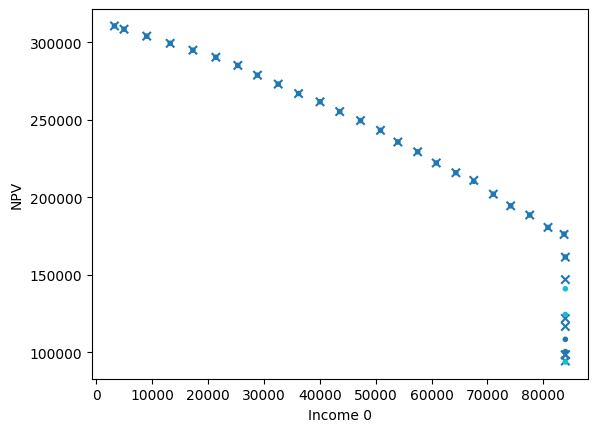

In [ ]:
labels = ["harvest5", "harvest25", "npv", "stock"]
namedict = {"harvest5": "Income 0", "harvest25": "Income 20", "stock": "Final timber volume", "npv": "NPV"}
ideals = {
        "harvest5": 83939.39118553553,
        "harvest25": 425351.15530470666,
        "stock": 5985.184367164438,
        "npv": 310523.6483315748,
    }
nadirs = {"harvest5": 0, "harvest25": 0, "stock": 260.7007001702532, "npv": 52844.33156539744}


objective_values = {label: [] for label in labels}
objective_values_rmop = {label: [] for label in labels}
xlabel = "harvest5"
ylabel = "npv"

npoints = 30
alphas_ts = []
alphas_rmop = []
worst_case_ts = []
worst_case_rmop = []
weights = []
for i in range(npoints+1):
    weight = i / npoints
    weights.append(weight)
    """
    reference = {
            "harvest5": weight*ideals["harvest5"]+(1-weight)*nadirs["harvest5"],
            "harvest25": (1-weight)*ideals["harvest25"]+weight*nadirs["harvest25"],
            "stock": nadirs["stock"],
            "npv": nadirs["npv"],
        }
        """
    reference = {}
    for label in labels:
        if label == xlabel:
            reference[label] = weight * ideals[label] + (1 - weight) * nadirs[label]
        elif label == ylabel:
            reference[label] = (1 - weight) * ideals[label] + weight * nadirs[label]
        else:
            reference[label] = -ideals[label]

    (model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case) = tsrmop_asf(reference=reference)
    alphas_ts.append(alpha)
    worst_case_ts.append(worst_case)

    results = {"harvest5": harvest5, "harvest25": harvest25, "stock": stock, "npv": npv}

    for label in labels:
        objective_values[label].append(min(var.x for var in results[label]))

    (model, harvest5, harvest25, stock, npv, alpha, mvars, worst_case) = rmop_asf(reference=reference)
    alphas_rmop.append(alpha)
    worst_case_rmop.append(worst_case)

    #print(f"Worst scenario ={worst_case}")
    # (model, harvest5, harvest25, stock, npv, alpha) = rmop_asf(reference=reference)
    results = {"harvest5": harvest5, "harvest25": harvest25, "stock": stock, "npv": npv}

    for label in labels:
        objective_values_rmop[label].append(min(var.x for var in results[label]))

    #if np.isclose(min(var.x for var in results[xlabel]), ideals[xlabel]):
    #    break

"""
    print(model.ObjVal)
    print("Harvest 5")
    print(harvest5[0].x)
    print(harvest5[1].x)
    print(harvest5[2].x)
    print(harvest5[3].x)
    print("harvest 25")
    print(harvest25[0].x)
    print(harvest25[1].x)
    print(harvest25[2].x)
    print(harvest25[3].x)
    print("stock")
    print(stock[0].x)
    print(stock[1].x)
    print(stock[2].x)
    print(stock[3].x)
    print("NPV")
    print(npv[0].x)
    print(npv[1].x)
    print(npv[2].x)
    print(npv[3].x)
    print()
"""

data = np.array([objective_values[label] for label in labels]).transpose()

ideal_vals = np.array([ideals[label] for label in labels])
nadir_vals = np.array([nadirs[label] for label in labels])
normed = (data - nadir_vals) / (ideal_vals - nadir_vals)

plt.close()


plt.scatter(objective_values_rmop[xlabel], objective_values_rmop[ylabel], c=worst_case_rmop, cmap="tab10", marker="x")
plt.scatter(objective_values[xlabel], objective_values[ylabel], c=worst_case_ts, cmap="tab10", marker=".", facecolors="none")
plt.xlabel(namedict[xlabel])
plt.ylabel(namedict[ylabel])

# Pick a colorblind-friendly palette
from matplotlib.cm import get_cmap
cmap = get_cmap("tab10")  # or "Set1", "Dark2", etc.

# Assign a color to each category
unique_cats = [range(1,5)]
colors = {cat: cmap(i) for i, cat in enumerate(unique_cats)}

# Plot each category separately
for cat in unique_cats:
    mask = worst_case_rmop == cat
    plt.scatter(objective_values_rmop[xlabel][mask], objective_values_rmop[ylabel][mask], label=f"Scenario {cat}",
                c=[colors[cat]], marker="x")
    
for cat in unique_cats:
    mask = worst_case_ts == cat
    plt.scatter(objective_values[xlabel][mask], objective_values[ylabel][mask], label=f"Scenario {cat}",
                c=[colors[cat]], marker="o")

plt.legend(title="Scenario")

plt.xlabel(namedict[xlabel])
plt.ylabel(namedict[ylabel])

# plt.title("Pareto frontier")
plt.savefig(f"figures/something_{xlabel}_{ylabel}.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()